In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.ioff()

In [2]:
fignum = 1
tmpdir = "/tmp/mpl"

In [3]:
%%bash -s "$tmpdir"

if [ -d "$1" ]
then 
    rm -rf "$1"
fi
mkdir "$1"

In [4]:
plt.get_fignums()

[]

In [5]:
def logger(fn):
    def wrapper(*args, **kwargs):
        print "Calling %s" % fn.__name__
        result = fn(*args, **kwargs)
        print "Returning %s (id: %s) from %s" % (result, id(result), fn.__name__)
        return result
    return wrapper
    
plt.gca = logger(plt.gca)
plt.gcf = logger(plt.gcf)
plt.figure = logger(plt.figure)
plt.close = logger(plt.close)

In [6]:
plt.hist(np.random.randn(1000))
plt.savefig('%s/%d.png' % (tmpdir, fignum))
fignum += 1
#plt.show();

Calling gca
Calling gcf
Calling figure
Returning Figure(480x320) (id: 4398163856) from figure
Returning Figure(480x320) (id: 4398163856) from gcf
Returning Axes(0.125,0.125;0.775x0.775) (id: 4398217552) from gca
Calling gcf
Returning Figure(480x320) (id: 4398163856) from gcf


In [7]:
plt.get_fignums()

[1]

The interactive backends (UI and Jupyter notebook), the `_pylab_helpers.destroy` function is called once the figure is shown. So, we end up with only 1 active figure in the queue at all times. However, when rendering a hardcopy the figure is not destroyed, and so calling any plot command will simply add to the current figure. There are two ways to prevent this from happening: first, you can call the `plt.clf()` function to clear the current figure before you reuse it, second, you can call the `plt.figure()` function to create a new figure.

In [8]:
plt.clf()

Calling gcf
Returning Figure(480x320) (id: 4398163856) from gcf


In [9]:
plt.plot(np.random.randn(100))
plt.savefig('%s/%d.png' % (tmpdir, fignum))
fignum += 1

Calling gca
Calling gcf
Returning Figure(480x320) (id: 4398163856) from gcf
Returning Axes(0.125,0.125;0.775x0.775) (id: 4399701904) from gca
Calling gcf
Returning Figure(480x320) (id: 4398163856) from gcf


In [10]:
plt.get_fignums()

[1]

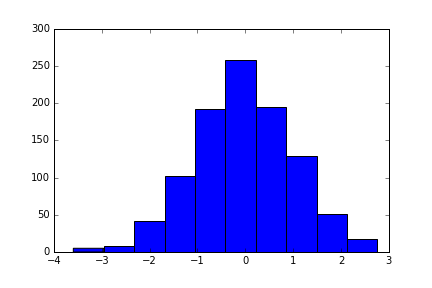

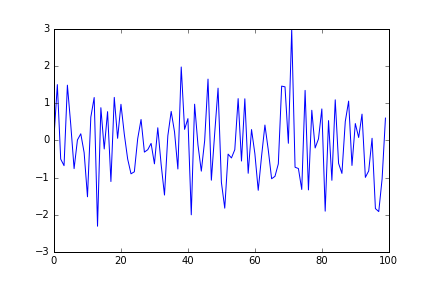

In [11]:
from IPython.display import Image, display_png
images = !ls /tmp/mpl/*.png
for img_fname in images:
    display_png(Image(filename=img_fname))

## Memory Management

In [ ]:
import warnings
warnings.simplefilter(action="always", category=RuntimeWarning)

In [ ]:
for i in range(21):
    plt.figure()
    plt.hist(np.random.randn(1000))

In [ ]:
plt.get_fignums()

### Why does this happen?

By default, the `pylot` plotting functions do not close figures as they're used. Instead, `pyplot` registers an event listener that destroys all figures in memory when your script comes to an end. While the script is running, however, the `pyplot` interface does actively manage memory by reusing a single figure over and over again. Basically, every time a figure is rendered (output to a file or displayed in a window) `pyplot` will clear the figure and reuse it for the next set of plotting commands. It grabs the current figure from the top of global stack, and it always checks the stack for a figure before it creates a new one. If the user calls the `figure` function directly, they bypass this check and create a new figure and add it to the top of the stack, and `pyplot` just uses that whenever plotting commands are called. This means that each time the figure 

In [ ]:
plt.close("all")

In [ ]:
for i in range(21):
    plt.figure()
    plt.hist(np.random.randn(1000))
    plt.show()
    #plt.close()

Now we no longer get a warning because we are closing each figure manually after we're finished with it.

In [ ]:
plt.get_fignums()